# Chapter 6 - Linear Model Selection and Regularization

### 6.5.1 Subset Selection Methods
Here we implement methods that reduce the number of parameters in a
model by restricting the model to a subset of the input variables.

In [1]:
#!pip install ISLP
#!pip install l0bnb

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)

from l0bnb import fit_path

In [4]:
import warnings
warnings.filterwarnings("ignore")

#### Forward Selection
We will apply the forward-selection approach to the Hitters data. We wish
to predict a baseball player’s Salary on the basis of various statistics associated with performance in the previous year.

In [5]:
# Read data
file = 'data/Hitters.csv'
hitters = pd.read_csv(file)
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [6]:
hitters = hitters.drop(columns=['Unnamed: 0'])

hitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [7]:
# Check for NA values in the DataFrame
na_counts = hitters.isna().sum()
na_counts

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [8]:
# Filter columns that contain NA values
columns_with_na = na_counts[na_counts > 0]

print(columns_with_na)

Salary    59
dtype: int64


In [9]:
hitters = hitters.dropna()

hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64(1), 

In [10]:
hitters.shape

(263, 20)

In [11]:
# Create dummy variables for qualitative features
qual = ['League', 'Division', 'NewLeague']

hitters = pd.get_dummies(hitters, columns=qual)  # Create dummy variables for the specified qualitative columns in 'qual'

hitters = hitters.astype(int)                 # Convert boolean columns to 0 and 1

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750,1,0,0,1,1,0


We first choose the best model using forward selection based on Cp. This score is not built in as a metric to sklearn. We therefore define a
function to compute it ourselves, and use it as a scorer. By default, sklear 
tries to maximize a score, hence our scoring function computes the negati e Cp
statistic.

In [12]:
def nCp(sigma2, estimator, X, Y):
    """
    Calculate the Negative Cp statistic.
    
    Parameters:
    sigma2 (float): The variance estimate of the error term.
    estimator (object): A fitted model with a 'predict' method.
    X (array-like): The feature matrix.
    Y (array-like): The target vector.

    Returns:
    float: The Negative Cp statistic value.
    """
    
    # Get the number of observations (n) and the number of features (p) from X
    n, p = X.shape
    
    # Use the estimator to predict the target values based on the feature matrix X
    Yhat = estimator.predict(X)
    
    # Calculate the residual sum of squares (RSS), which is the sum of squared differences between the actual and predicted values
    RSS = np.sum((Y - Yhat)**2)
    
    # Calculate and return the Negative Cp statistic, which is given by the formula:
    # -(RSS + 2 * p * sigma2) / n
    return -(RSS + 2 * p * sigma2) / n


We need to estimate the residual variance σ2, which is the first argument in our scoring function above. We will fit the biggest model, using all the
variables, and estimate σ2 based on its MSE.

In [13]:
# Fit a feature transformation model to the dataset, excluding the 'Salary' column
design = MS(hitters.columns.drop('Salary')).fit(hitters)

# Extract the target variable 'Salary' from the dataset and convert it to a NumPy array
Y = np.array(hitters['Salary'])

# Transform the dataset using the fitted transformation model to create feature matrix X
X = design.transform(hitters)

# Fit an Ordinary Least Squares (OLS) model to the transformed features (X) and target (Y)
sigma2 = OLS(Y, X).fit().scale

The function sklearn_selected() expects a scorer with just three arguments — the last three in the definition of nCp() above. We use the function
partial() first seen in Section 5.3.3 to freeze the first argument with our
estimate of σ2.

In [14]:
neg_Cp = partial(nCp, sigma2)

We can now use `neg_Cp()` as a scorer for model selection.

Along with a score we need to specify the search strategy. This is done through the object `Stepwise()` in the ISLP.models package. The method
`Stepwise.first_peak()` runs forward stepwise until any further additions to the model do not result in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()` runs a fixed number of steps of stepwise search.

In [15]:
# Initialize the stepwise regression strategy
strategy = Stepwise.first_peak(  
    design,                      # Feature transformation model used for stepwise regression
    direction='forward',         # Specify forward selection direction for adding features
    max_terms=len(design.terms)  # Set the maximum number of terms to the number of features in the design
)

We now fit a linear regression model with Salary as outcome using forward selection. To do so, we use the function `sklearn_selected()` from the
sklearn_ISLP.models package. This takes a model from statsmodels along with a selected()
search strategy and selects a model with its fit method. Without specifying a scoring argument, the score defaults to MSE, and so all 19 variables
will be selected (output not shown).

In [16]:
hitters_MSE = sklearn_selected(  # Create an instance of the sklearn_selected class using OLS and the stepwise strategy
    OLS,                         # Ordinary Least Squares model
    strategy                     # Stepwise selection strategy to be used
)

hitters_MSE.fit(  # Fit the sklearn_selected model to the data
    hitters,      # Input feature matrix
    Y             # Target variable
)

hitters_MSE.selected_state_  # Retrieve the state of the selected features from the fitted model

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division_E',
 'Errors',
 'Hits',
 'HmRun',
 'League_A',
 'League_N',
 'NewLeague_A',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

This is a tuple of feature names that were selected by the model as the most relevant predictors based on the MSE criterion. These are the features that contributed most to minimizing the MSE in the fitted model.

Using neg_Cp results in a smaller model, as expected, with just 10 variables selected.

In [17]:
hitters_Cp = sklearn_selected(  # Create an instance of the sklearn_selected class using OLS, stepwise strategy, and a custom scoring function
    OLS,                        # Ordinary Least Squares model
    strategy,                   # Stepwise selection strategy to be used
    scoring=neg_Cp              # Custom scoring function for evaluating model performance
)

hitters_Cp.fit(  # Fit the sklearn_selected model to the data
    hitters,     # Input feature matrix
    Y            # Target variable
)

hitters_Cp.selected_state_  # Retrieve the state of the selected features from the fitted model

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division_E',
 'Hits',
 'PutOuts',
 'Walks')

This tuple contains the names of the features that were selected by the model as the most relevant predictors based on the Cp statistic criterion. These features are considered the most important for the model according to the custom scoring function used.

#### Choosing Among Models Using the Validation Set Approach and Cross-Validation

As an alternative to using Cp, we might try cross-validation to select a model in forward selection. For this, we need a method that stores the
full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()` estimator from ISLP.models. The function `cross_val_predict()` from ISLP.models computes the cross-validated predictions for each of the models along the path, which we can use to evaluate the cross-validated MSE along the path.

Here we define a strategy that fits the full forward selection path. While there are various parameter choices for `sklearn_selection_path()`, we use
the defaults here, which selects the model at each step based on the biggestreduction in RSS.uction in RSS.

In [18]:
strategy = Stepwise.fixed_steps(
    design,               # The design matrix for the regression model, which includes all features
    len(design.terms),    # The total number of features to consider in the selection process
    direction='forward'   # Direction of feature selection: 'forward' means adding features one by one
)

full_path = sklearn_selection_path(
    OLS,                   # The Ordinary Least Squares model to be used for regression
    strategy               # The stepwise selection strategy defined above
)

We now fit the full forward-selection path on the Hitters data and compute the fitted values.

In [19]:
full_path.fit(hitters, Y)             # Fit the model selection path to the data using the Hitters dataset and target variable Y
Yhat_in = full_path.predict(hitters)  # Predict target values using the fitted model and the Hitters dataset
Yhat_in.shape                         # Get the shape of the predicted values array

(263, 23)

This gives us an array of fitted values — 20 steps in all, including the
fitted mean for the null model — which we can use to evaluate in-sample
MSE. As expected, the in-sample MSE improves each step we take, indicating we must use either the validation or cross-validation approach to select
the number of steps. We fix the y-axis to range from 50,000 to 250,000
to compare to the cross-validation and validation set MSE below, as well
as other methods such as ridge regression, lasso and principal components
regression.

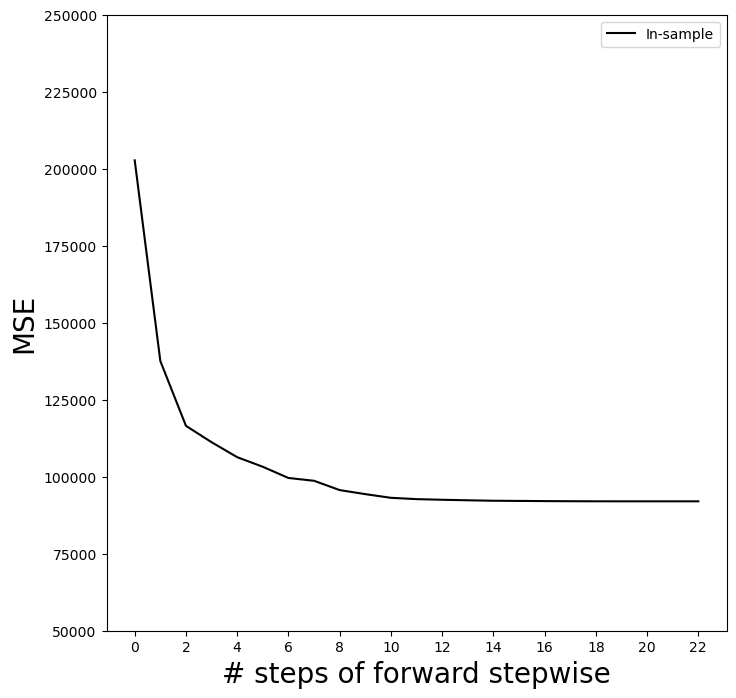

In [20]:
mse_fig, ax = subplots(figsize=(8, 8))              # Create a figure and axis for plotting with a specified figure size of 8x8 inches
insample_mse = ((Yhat_in - Y[:, None])**2).mean(0)  # Compute the mean squared error (MSE) for each step of the forward stepwise selection
n_steps = insample_mse.shape[0]                     # Determine the number of steps in the forward stepwise process
ax.plot(
    np.arange(n_steps),  # X-axis: range of steps
    insample_mse,        # Y-axis: MSE values
    'k',                 # Color: black
    label='In-sample'    # Label for the plot
)
ax.set_ylabel(
    'MSE',               # Y-axis label
    fontsize=20          # Font size for the Y-axis label
)
ax.set_xlabel(
    '# steps of forward stepwise',  # X-axis label
    fontsize=20                     # Font size for the X-axis label
)
ax.set_xticks(np.arange(n_steps)[::2])  # Set X-axis ticks to show every other step
ax.legend()                             # Display the legend for the plot
ax.set_ylim([50000, 250000]);           # Set the Y-axis limits to range from 50,000 to 250,000

Notice the expression None in Y[:,None] above. This adds an axis (dimension) to the one-dimensional array Y, which allows it to be recycled when
subtracted from the two-dimensional Yhat_in.

We are now ready to use cross-validation to estimate test error along
the model path. We must use only the training observations to perform
all aspects of model-fitting — including variable selection. Therefore, the
determination of which model of a given size is best must be made using
only the training observations in each training fold. This point is subtle but
important. If the full data set is used to select the best subset at each step,
then the validation set errors and cross-validation errors that we obtain
will not be accurate estimates of the test error.

We now compute the cross-validated predicted values using 5-fold crossvalidation.

In [21]:
K = 5                # Number of folds for cross-validation

kfold = skm.KFold(
    K,               # Number of splits (folds)
    random_state=0,  # Seed for random number generator to ensure reproducibility
    shuffle=True     # Whether to shuffle the data before splitting into batches
)
Yhat_cv = skm.cross_val_predict(
    full_path,       # Model selection path to be evaluated
    hitters,         # Input feature matrix
    Y,               # Target variable
    cv=kfold         # Cross-validation strategy
)
Yhat_cv.shape        # Get the shape of the cross-validated predictions array

(263, 23)

The prediction matrix Yhat_cv is the same shape as Yhat_in; the difference is that the predictions in each row, corresponding to a particular sample
index, were made from models fit on a training fold that did not include that row.

At each model along the path, we compute the MSE in each of the crossvalidation folds. These we will average to get the mean MSE, and can also
use the individual values to compute a crude estimate of the standard error of the mean. Hence we must know the test indices for each cross-validation
split. This can be found by using the `split()` method of kfold. Because we fixed the random state above, whenever we split any array with the same
number of rows as Y we recover the same training and test indices, though we simply ignore the training indices below.

In [22]:
cv_mse = []  # Initialize an empty list to store cross-validation MSE values

for train_idx, test_idx in kfold.split(Y):               # Iterate over the splits created by KFold
    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2  # Compute squared errors for the test set
    cv_mse.append(errors.mean(0))                        # Calculate mean squared error for each test set and append to the list

cv_mse = np.array(cv_mse).T  # Convert list of MSE values to a NumPy array and transpose it
cv_mse.shape                 # Get the shape of the cross-validation MSE array

(23, 5)

We now add the cross-validation error estimates to our MSE plot. We
include the mean error across the five folds, and the estimate of the standard
error of the mean.

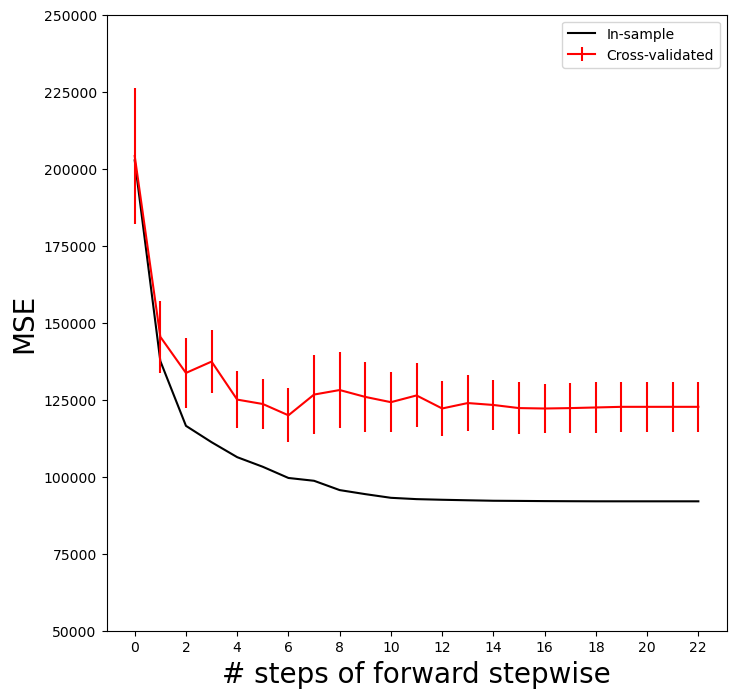

In [23]:
ax.errorbar(
    np.arange(n_steps),          # X-axis values: number of steps in forward stepwise
    cv_mse.mean(1),              # Mean cross-validated MSE values for each step
    cv_mse.std(1) / np.sqrt(K),  # Standard error of the mean for cross-validated MSE values
    label='Cross-validated',     # Label for the error bar plot
    c='r'                        # Color of the error bars: red
) 
ax.set_ylim([50000, 250000])  # Set the y-axis limits for the plot
ax.legend()                   # Display the legend for the plot
mse_fig                       # Display the figure with the error bars

To repeat the above using the validation set approach, we simply change
our cv argument to a validation set: one random split of the data into a
test and training. We choose a test size of 20%, similar to the size of each
test set in 5-fold cross-validation.

In [24]:
validation = skm.ShuffleSplit(  # Create a ShuffleSplit object for validation
    n_splits=1,                 # Number of re-shuffling and splitting iterations
    test_size=0.2,              # Proportion of the data to include in the test split
    random_state=0              # Seed for the random number generator
)

# Iterate over the train-test splits generated by ShuffleSplit
for train_idx, test_idx in validation.split(Y):
    
    # Fit the model on the training data
    full_path.fit(hitters.iloc[train_idx],  # Training feature matrix
                  Y[train_idx])             # Training target variable
    
    # Predict on the validation data
    Yhat_val = full_path.predict(hitters.iloc[test_idx])  # Predicted values on the test set
    
    # Calculate the mean squared error (MSE) for the validation predictions
    errors = (Yhat_val - Y[test_idx, None])**2    # Squared errors between predictions and actual values
    validation_mse = errors.mean(0)               # Mean MSE across all features

As for the in-sample MSE case, the validation set approach does not provide standard errors.

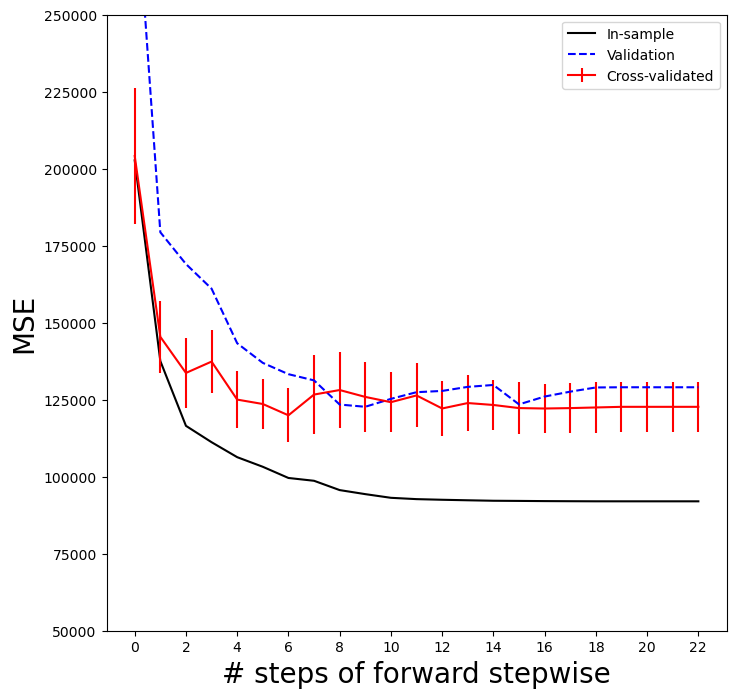

In [25]:
ax.plot(np.arange(n_steps),   # X-axis: number of steps
        validation_mse,       # Y-axis: validation mean squared error
        'b--',                # Line style: blue dashed line
        label='Validation')   # Label for the validation curve in the legend

# Set x-axis ticks to every other step
ax.set_xticks(np.arange(n_steps)[::2])

# Set y-axis limits for the plot
ax.set_ylim([50000, 250000])

# Add a legend to the plot
ax.legend()

# Display the figure
mse_fig

#### Best Subset Selection
Forward stepwise is a greedy selection procedure; at each step it augments
the current set by including one additional variable. We now apply best
subset selection to the Hitters data, which for every subset size, searches
for the best set of predictors.

We will use a package called l0bnb to perform best subset selection.
Instead of constraining the subset to be a given size, this package produces a
path of solutions using the subset size as a penalty rather than a constraint.
Although the distinction is subtle, the difference comes when we cross-validate.

In [26]:
D = design.fit_transform(hitters)  # Apply the design matrix transformation to the Hitters dataset

D = D.drop('intercept', axis=1)    # Drop the 'intercept' column from the transformed design matrix

X = np.asarray(D)                  # Convert the DataFrame to a NumPy array

Here we excluded the first column corresponding to the intercept, as l0bnb
will fit the intercept separately. We can find a path using the `fit_path()`
function.

In [27]:
path = fit_path(
    X,                        # Input feature matrix
    Y,                        # Target variable
    max_nonzeros=X.shape[1]   # Maximum number of non-zero coefficients to consider in the path
)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  19
Iteration: 10. Number of non-zeros:  22


The function `fit_path()` returns a list whose values include the fitted coefficients as B, an intercept as B0, as well as a few other attributes related to the particular path algorithm used.

In [28]:
path[3]  # Accesses the fourth element in the path

{'B': array([0.        , 3.25500932, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67766637, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 'B0': -39.045691558997305,
 'lambda_0': 0.01141749374070153,
 'M': 0.5829383246254924,
 'Time_exceeded': False}

In the example above, we see that at the fourth step in the path, we have
two nonzero coefficients in 'B', corresponding to the value 0.114 for the
penalty parameter lambda_0. We could make predictions using this sequence
of fits on a validation set as a function of lambda_0, or with more work using
cross-validation.

In [29]:
from sklearn.linear_model import ElasticNet

# Standardize X
s = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = s / X_scale[None,:]

# Define lambdas
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

# Perform ElasticNet path with L1 regularization (e.g., l1_ratio=0.5)
soln_array = ElasticNet(l1_ratio=0.5, max_iter=10000).path(Xs, Y, alphas=lambdas)[1]

# Check shape of solution array
soln_array.shape


(22, 100)

In [30]:
from sklearn.linear_model import ElasticNet

# Standardize X
s = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = s / X_scale[None,:]

# Define lambdas
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

# Create ElasticNet object with increased number of iterations
elastic_net = ElasticNet(l1_ratio=0.5, max_iter=10000)  # Increased max_iter

# Perform ElasticNet path
soln_array = elastic_net.path(Xs, Y, alphas=lambdas)[1]

# Check shape of solution array
soln_array.shape

(22, 100)

Here we extract the array of coefficients corresponding to the solutions along the regularization path.
By default the `skl.ElasticNet.path` method fits a path along
an automatically selected range of $\lambda$ values, except for the case when
`l1_ratio=0`, which results in ridge regression (as is the case here). {The reason is rather technical; for all models except ridge, we can find the smallest value of $\lambda$ for which all coefficients are zero. For ridge this value is $\infty$.}  So here
we have chosen to implement the function over a grid of values ranging
from $\lambda=10^{8}$ to $\lambda=10^{-2}$ scaled by the standard
deviation of $y$, essentially covering the full range of scenarios
from the null model containing only the intercept, to the least
squares fit.

Associated with each value of $\lambda$ is a vector of ridge
regression coefficients,   that can be accessed by
a column of `soln_array`. In this case, `soln_array` is a $19 \times 100$ matrix, with
19 rows (one for each predictor) and 100
columns (one for each value of $\lambda$).

We transpose this matrix and turn it into a data frame to facilitate viewing and plotting.

In [31]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CWalks,PutOuts,Assists,Errors,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
negative log(lambda),,,,,,,,,,,,,,,,,,,,,
-12.310900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
-12.078316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
-11.845732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
-11.613147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
-11.380563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784613,-290.967472,337.458072,37.640511,-60.183861,-26.825474,134.954201,-16.952538,-389.429920,88.056647,-13.287431,...,-213.412238,78.764113,53.674524,-22.175083,-15.610440,15.638356,29.163984,-29.253683,6.134334,-6.249484
10.017198,-290.995805,337.552081,37.695968,-60.269795,-26.876408,134.976938,-16.898134,-389.769485,87.754875,-13.486640,...,-213.492232,78.764124,53.686043,-22.170110,-15.609598,15.637748,29.161309,-29.251630,6.130867,-6.246886
10.249782,-291.018345,337.626883,37.740064,-60.338154,-26.916904,134.995014,-16.854989,-390.038033,87.513220,-13.645309,...,-213.555929,78.764136,53.695160,-22.166148,-15.608920,15.637260,29.159185,-29.250000,6.128102,-6.244817


We plot the paths to get a sense of how the coefficients vary with lambda. To control the location of the legend we first set `legend` to `False` in the plot method, adding it afterward with the `legend()` method of `ax`.

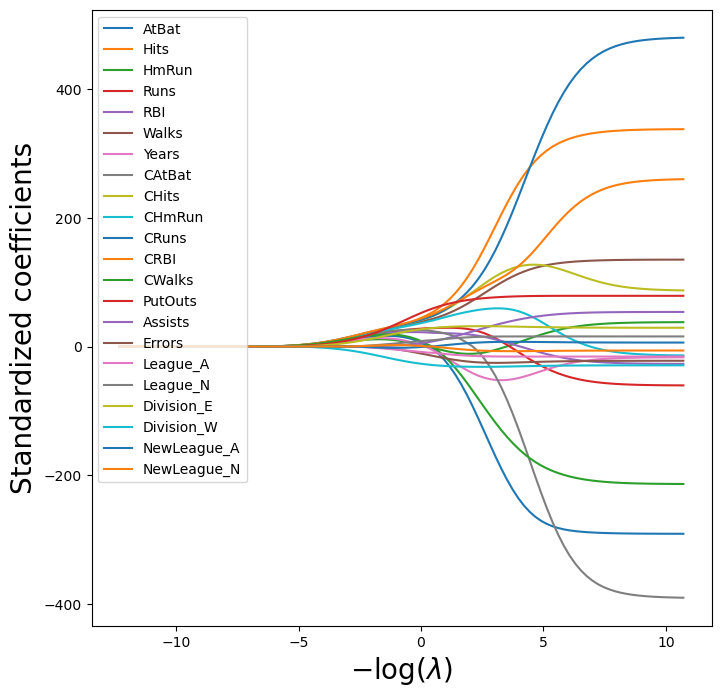

In [32]:
path_fig, ax = subplots(figsize=(8,8))                   # Create a figure and axes for plotting with a size of 8x8 inches
soln_path.plot(ax=ax, legend=False)                      # Plot the solution path on the created axes without showing a legend
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)           # Set the x-axis label as '-log(lambda)' with font size 20
ax.set_ylabel('Standardized coefficients', fontsize=20)  # Set the y-axis label as 'Standardized coefficients' with font size 20
ax.legend(loc='upper left');                             # Add a legend to the plot, positioned at the upper left

(We have used `latex` formatting in the horizontal label, in order to format the Greek $\lambda$ appropriately.) We expect the coefficient estimates to be much smaller, in terms of l2 norm, when a large value of $\lambda$ is used, as compared to when a small value of $\lambda$ is used. (Recall that the l2 norm is the square root of the sum of squared coefficient values.) We display the coefficients at the 
40th step, where $\lambda$ is 25.535.

In [33]:
beta_hat = soln_path.loc[soln_path.index[39]]  # Extract the coefficients from the 40th row (index 39) of soln_path
lambdas[39], beta_hat                          # Return the 40th lambda value and the corresponding coefficients

(25.536544093842224,
 AtBat           8.201342
 Hits            9.786621
 HmRun           6.585196
 Runs            9.078976
 RBI             9.496897
 Walks           9.852475
 Years           7.696395
 CAtBat         10.994270
 CHits          11.764524
 CHmRun         11.116565
 CRuns          12.076150
 CRBI           12.193242
 CWalks          9.965097
 PutOuts         7.426751
 Assists         0.000000
 Errors         -0.000000
 League_A       -0.000000
 League_N        0.000000
 Division_E      4.562416
 Division_W     -4.562415
 NewLeague_A    -0.000000
 NewLeague_N     0.000000
 Name: -3.2401105279734534, dtype: float64)

Let’s compute the l2 norm of the standardized coefficients.

In [34]:
np.linalg.norm(beta_hat)  # Calculate the Euclidean norm (L2 norm) of the beta_hat coefficients

37.53378524974069

In [35]:
beta_hat = soln_path.loc[soln_path.index[59]]  # Extract the coefficients from the 60th row (index 59) of soln_path
lambdas[59], np.linalg.norm(beta_hat)          # Return the 60th lambda value and the Euclidean norm of the corresponding coefficients

(0.24375868753253987, 198.6016853151447)

#### Lambda Value (0.24375868753253987):
This is the value of the regularization parameter, lambda, at the 60th position in the sequence of lambda values used in the model. The lambda parameter controls the amount of regularization applied to the model's coefficients to prevent overfitting. A smaller lambda value generally allows for more flexibility in the model (less regularization), while a larger value tends to shrink coefficients, imposing more regularization.

#### Euclidean Norm of Coefficients (198.6016853151447):
The Euclidean norm (L2 norm) of the beta_hat vector represents the magnitude of the model coefficients at the given lambda. In this case, 198.6016853151447 is the sum of the squared coefficients, which has been square-rooted. A higher norm indicates that the coefficients have a larger overall magnitude, which usually corresponds to a model with less regularization. This is because a smaller lambda allows the coefficients to take on larger values, thus resulting in a larger norm.

In [36]:
ridge = skl.ElasticNet(alpha=lambdas[59],    # Initialize ElasticNet with regularization strength based on the 60th lambda value
                       l1_ratio=0)           # Set l1_ratio to 0 to use pure Ridge (L2) regularization

scaler = StandardScaler(with_mean=True,      # Standardize the features by centering them to have mean=0
                        with_std=True)       # Scale features to have unit variance

pipe = Pipeline(steps=[('scaler', scaler),   # Create a pipeline to standardize the data before model fitting
                       ('ridge', ridge)])    # Add the Ridge regression model (ElasticNet with l1_ratio=0) to the pipeline

pipe.fit(X, Y)                               # Fit the pipeline to the feature matrix X and target vector Y

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.24375868753253987, l1_ratio=0))])

We show that it gives the same l2 norm as in our previous fit on the standardized data.

In [37]:
np.linalg.norm(ridge.coef_)  # Calculate the Euclidean norm (L2 norm) of the coefficients of the fitted Ridge regression model

156.58537544402617

Notice that the operation `pipe.fit(X, Y)` above has changed the `ridge` object, and in particular has added attributes such as `coef_` that were not there before.

Estimating Test Error of Ridge Regression Choosing an a priori value of $\lambda$ for ridge regression is difficult if not impossible. We will want to use the validation method or cross-validation to select the tuning parameter. The reader may not be surprised that the `Pipeline()` approach can be used in `skm.cross_validate()` with either a validation method (i.e. `validation`) or k-fold cross-validation.

We fix the random state of the splitter so that the results obtained will be reproducible.

In [38]:
validation = skm.ShuffleSplit(n_splits=1,       # Create a single-split validation strategy for cross-validation
                              test_size=0.5,    # Set the test set to be 50% of the data
                              random_state=0)   # Set a random state for reproducibility of splits

ridge.alpha = 0.01                              # Update the alpha parameter of the Ridge model to 0.01, altering regularization strength

results = skm.cross_validate(ridge,    # Perform cross-validation using the Ridge model
                             X,        # Feature matrix to train and validate the model
                             Y,        # Target vector for prediction
                             scoring='neg_mean_squared_error',  # Use negative mean squared error as the scoring metric
                             cv=validation)                     # Use the ShuffleSplit validation strategy for cross-validation

-results['test_score']                 # Return the negated test score to get the actual mean squared error of the model

array([134225.96098162])

The test MSE is 1.342e+05. Note that if we had instead simply fit a model with just an intercept, we would have predicted each test observation using the mean of the training observations. We can get the same result by fitting a ridge regression model with a very large value of $\lambda$. Note that 1e10 means 10^10.

In [39]:
ridge.alpha = 1e10                  # Set the alpha parameter of the Ridge model to a very large value (1e10), imposing strong regularization

results = skm.cross_validate(ridge, # Perform cross-validation using the updated Ridge model
                             X,     # Feature matrix for training and testing
                             Y,     # Target vector to predict
                             scoring='neg_mean_squared_error',  # Use negative mean squared error as the scoring metric
                             cv=validation)                     # Use the ShuffleSplit validation strategy for cross-validation

-results['test_score']     # Return the negated test score to obtain the actual mean squared error of the model

array([231747.97905999])

Obviously choosing $\lambda=0.01$ is arbitrary,  so we will  use cross-validation or the validation-set
approach to choose the tuning parameter $\lambda$.
The object `GridSearchCV()`  allows exhaustive
grid search to choose such a parameter.

We first use the validation set method
to choose $\lambda$.

In [40]:
param_grid = {'ridge__alpha': lambdas}     # Define a parameter grid for GridSearchCV to test different values of alpha for Ridge regression

grid = skm.GridSearchCV(pipe,              # Initialize GridSearchCV with the pipeline (scaling + ridge regression)
                        param_grid,        # Specify the parameter grid containing different alpha values
                        cv=validation,     # Use the ShuffleSplit validation strategy for cross-validation
                        scoring='neg_mean_squared_error')  # Optimize the model based on the negative mean squared error

grid.fit(X, Y)                     # Fit the GridSearchCV on the feature matrix X and target vector Y to find the best alpha

grid.best_params_['ridge__alpha']  # Retrieve the best alpha value found during the grid search

grid.best_estimator_               # Retrieve the best model (pipeline with the best alpha) found during the grid search

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899272894866821, l1_ratio=0))])

Alternatively, we can use 5-fold cross-validation.

In [41]:
grid = skm.GridSearchCV(pipe,          # Initialize GridSearchCV to tune the pipeline (scaling + ridge regression)
                        param_grid,    # Use the parameter grid with different alpha values for Ridge
                        cv=kfold,      # Use KFold cross-validation strategy for splitting the data
                        scoring='neg_mean_squared_error')  # Optimize based on negative mean squared error as the evaluation metric

grid.fit(X, Y)                     # Fit the GridSearchCV on the feature matrix X and target vector Y to find the best alpha

grid.best_params_['ridge__alpha']  # Retrieve the optimal alpha value found during the grid search process

grid.best_estimator_               # Retrieve the best pipeline (scaler + ridge) with the optimal alpha found

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.011853013791503853, l1_ratio=0))])

Recall we set up the `kfold` object for 5-fold cross-validation on page~\pageref{line:choos-among-models}. We now plot the cross-validated MSE as a function of $-\log(\lambda)$, which has shrinkage decreasing from left
to right.

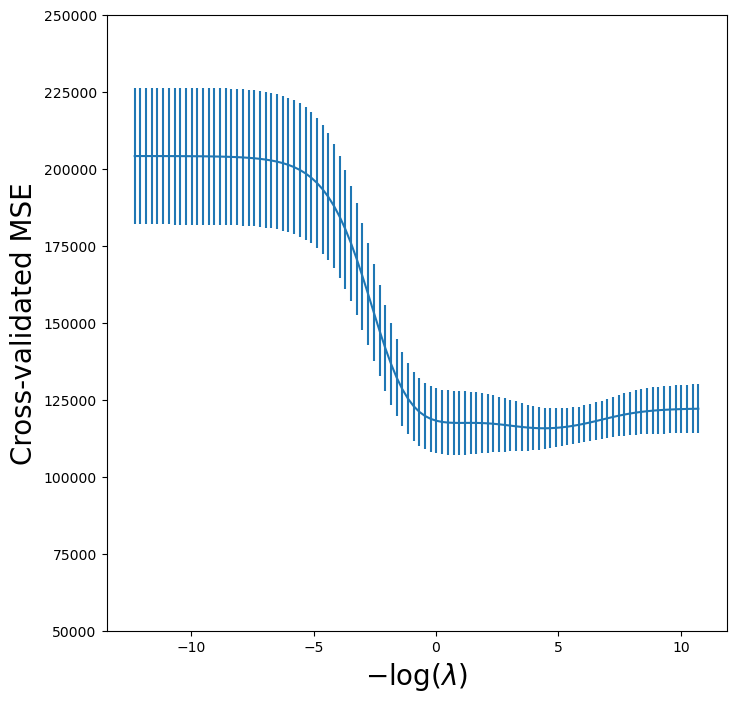

In [42]:
ridge_fig, ax = subplots(figsize=(8,8))              # Create a new figure and axes for plotting with a size of 8x8 inches

ax.errorbar(-np.log(lambdas),                        # Plot the negative log of lambda values on the x-axis
            -grid.cv_results_['mean_test_score'],    # Plot the negated mean cross-validated test score (MSE) on the y-axis
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))  # Add error bars using the standard error of the mean test score

ax.set_ylim([50000, 250000])                         # Set the limits of the y-axis to range from 50,000 to 250,000
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)       # Label the x-axis with '-log(lambda)' using font size 20
ax.set_ylabel('Cross-validated MSE', fontsize=20);   # Label the y-axis with 'Cross-validated MSE' using font size 20

One can cross-validate different metrics to choose a parameter. The default
metric for `skl.ElasticNet()` is test $R^2$.
Let’s compare $R^2$ to MSE for cross-validation here.

In [43]:
grid_r2 = skm.GridSearchCV(pipe,        # Initialize GridSearchCV to tune the pipeline (scaling + ridge regression)
                           param_grid,  # Use the parameter grid containing different alpha values for Ridge
                           cv=kfold)    # Use KFold cross-validation strategy for splitting the data

grid_r2.fit(X, Y)                       # Fit the GridSearchCV on the feature matrix X and target vector Y to find the best alpha

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22103838e+05, 1.76013493e+05, 1.39487683e+05, 1.10541603e+05,
       8.76023302e+04, 6.94233485e+04, 5.50168165e+04, 4.35998862e+04,
       3.45521642e+04, 2.73819992...
       4.67507288e-03, 3.70491531e-03, 2.93608202e-03, 2.32679479e-03,
       1.84394508e-03, 1.46129494e-03, 1.15805125e-03, 9.17735811e-04,
       7.27289935e-04, 5.76364836e-04, 4.56759276e-04, 3.61973915e-04,
       2.86858137e-04, 2.27330168e-04, 1.80155270e-04, 1.42769971e-04,
       1.13142760e-04, 8.96637025e-05, 7.10569509e-05, 5.63114184e-05,
       4.46258360e-05, 3.53652119e-05, 2.80263256e-05, 2.22103838e-05])})

Finally, let’s plot the results for cross-validated $R^2$.

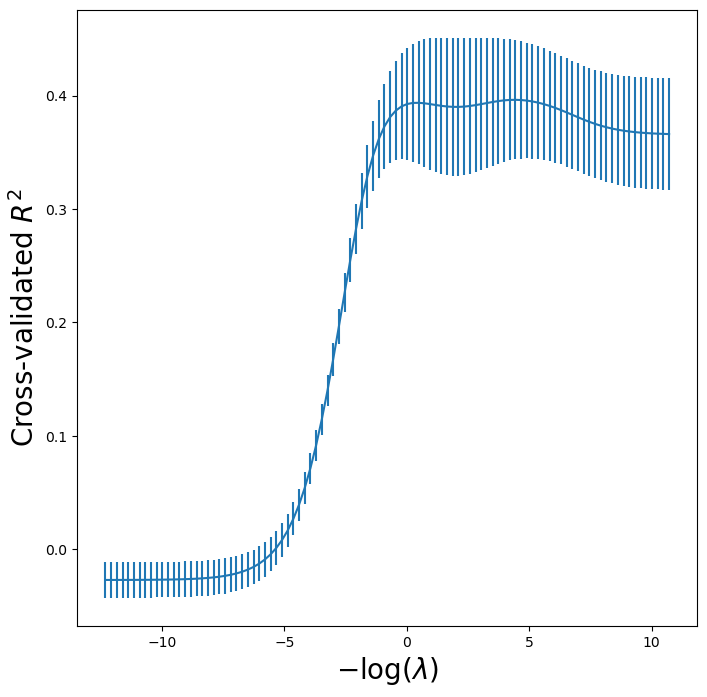

In [44]:
r2_fig, ax = subplots(figsize=(8,8))                    # Create a new figure and axes for plotting with a size of 8x8 inches

ax.errorbar(-np.log(lambdas),                           # Plot the negative log of lambda values on the x-axis
            grid_r2.cv_results_['mean_test_score'],     # Plot the mean cross-validated R² score on the y-axis
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))  # Add error bars using the standard error of the mean R² score

ax.set_xlabel('$-\log(\lambda)$', fontsize=20)          # Label the x-axis as '-log(lambda)' with a font size of 20
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);    # Label the y-axis as 'Cross-validated R²' with a font size of 20

### Fast Cross-Validation for Solution Paths
The ridge, lasso, and elastic net can be efficiently fit along a sequence of $\lambda$ values, creating what is known as a *solution path* or *regularization path*. Hence there is specialized code to fit
such paths, and to choose a suitable value of $\lambda$ using cross-validation. Even with
identical splits the results will not agree *exactly* with our `grid`
above because the standardization of each feature  in `grid` is carried out on each fold,
while in `pipeCV` below it is carried out only once.
Nevertheless, the results are similar as the normalization
is relatively stable across folds.

In [45]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas,        # Initialize ElasticNetCV to find the best alpha value from the given lambda array
                           l1_ratio=0,            # Set l1_ratio to 0 to make it equivalent to Ridge (L2) regression
                           cv=kfold)              # Use KFold cross-validation to evaluate different alpha values

pipeCV = Pipeline(steps=[('scaler', scaler),      # Create a pipeline to standardize the data before model fitting
                         ('ridge', ridgeCV)])     # Add the RidgeCV model (ElasticNetCV with l1_ratio=0) to the pipeline

pipeCV.fit(X, Y)      # Fit the pipeline on the feature matrix X and target vector Y to find the best alpha and train the model

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22103838e+05, 1.76013493e+05, 1.39487683e+05, 1.10541603e+05,
       8.76023302e+04, 6.94233485e+04, 5.50168165e+04, 4.35998862e+04,
       3.45521642e+04, 2.73819992e+04, 2.16997661e+04, 1.71966935e+04,
       1.36280855e+04, 1.08000247e+04, 8.55883489e+03, 6.78273028e+03,
       5.37519775e+03, 4.25975229e+03,...
       1.84394508e-03, 1.46129494e-03, 1.15805125e-03, 9.17735811e-04,
       7.27289935e-04, 5.76364836e-04, 4.56759276e-04, 3.61973915e-04,
       2.86858137e-04, 2.27330168e-04, 1.80155270e-04, 1.42769971e-04,
       1.13142760e-04, 8.96637025e-05, 7.10569509e-05, 5.63114184e-05,
       4.46258360e-05, 3.53652119e-05, 2.80263256e-05, 2.22103838e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Let’s produce a plot again of the cross-validation error to see that
it is similar to using `skm.GridSearchCV`.

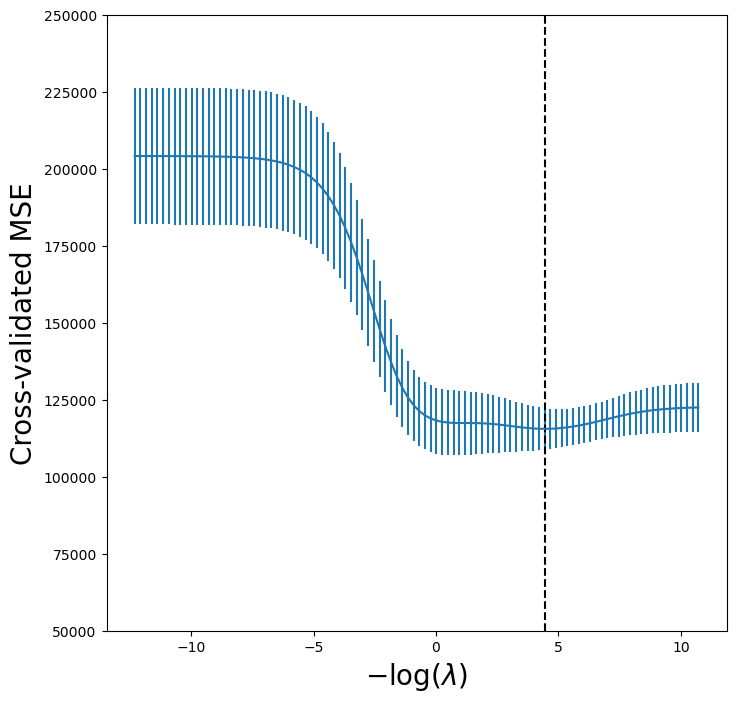

In [46]:
tuned_ridge = pipeCV.named_steps['ridge']          # Extract the trained ElasticNetCV (RidgeCV) model from the pipeline

ridgeCV_fig, ax = subplots(figsize=(8,8))          # Create a new figure and axes for plotting with a size of 8x8 inches

ax.errorbar(-np.log(lambdas),                      # Plot the negative log of lambda values on the x-axis
            tuned_ridge.mse_path_.mean(1),         # Plot the mean cross-validated MSE for each lambda on the y-axis
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))  # Add error bars to represent the standard error of the MSE

ax.axvline(-np.log(tuned_ridge.alpha_),            # Draw a vertical line at the optimal lambda value found by RidgeCV
           c='k',                                  # Set the color of the line to black
           ls='--')                                # Use a dashed line style for the vertical line

ax.set_ylim([50000, 250000])                       # Set the limits of the y-axis to range from 50,000 to 250,000
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)     # Label the x-axis as '-log(lambda)' with a font size of 20
ax.set_ylabel('Cross-validated MSE', fontsize=20); # Label the y-axis as 'Cross-validated MSE' with a font size of 20

We see that the value of $\lambda$ that results in the
smallest cross-validation error is 1.19e-02, available
as the value `tuned_ridge.alpha_`. What is the test MSE
associated with this value of $\lambda$?

In [47]:
np.min(tuned_ridge.mse_path_.mean(1))  # Find and return the minimum mean cross-validated MSE across all lambda values

115548.87676840453

This line of code calculates the **minimum mean cross-validated MSE** from the `mse_path_` of the `tuned_ridge` model (the `ElasticNetCV` instance extracted from the pipeline). The `mse_path_` stores the mean squared errors for each fold and each `lambda` value tested during cross-validation. By applying `np.min()`, you identify the lowest mean MSE, which indicates the best performance achieved across all regularization strengths.

This represents a further improvement over the test MSE that we got
using $\lambda=4$.  

Finally, `tuned_ridge.coef_`
has the coefficients fit on the entire data set
at this value of  $\lambda$.

In [48]:
tuned_ridge.coef_  # Retrieve the coefficients of the model corresponding to the optimal alpha after cross-validation

array([-222.53242025,  238.74326618,    3.34343218,   -3.05268308,
          3.44346991,  108.94996122,  -50.84690618, -105.0732317 ,
        122.16662275,   57.12774542,  210.18564107,  118.0587775 ,
       -150.25687242,   77.72224102,   40.04785979,  -25.06985294,
        -15.66415609,   15.66415602,   30.99350031,  -30.9935    ,
          7.30444702,   -7.30444656])

As expected, none of the coefficients are zero—ridge regression does
not perform variable selection!

### Evaluating Test Error of Cross-Validated Ridge
Choosing $\lambda$ using cross-validation provides a single regression
estimator, similar to fitting a linear regression model as we saw in
Chapter~\ref{Ch3:linreg}. It is therefore reasonable to estimate what its test error
is. We run into a problem here in that cross-validation will have
*touched* all of its data in choosing $\lambda$, hence we have no
further data to estimate test error. A compromise is to do an initial
split of the data into two disjoint sets: a training set and a test set.
We then fit a cross-validation
tuned ridge regression on the training set, and evaluate its performance on the test set.
We might call this cross-validation nested
within the validation set approach. A priori there is no reason to use
half of the data for each of the two sets in validation. Below, we use
75% for training and 25% for test, with the estimator being ridge
regression tuned using 5-fold cross-validation.  This can be achieved
in code as follows:

In [49]:
outer_valid = skm.ShuffleSplit(n_splits=1,       # Create a single split for outer cross-validation
                               test_size=0.25,   # Set the test set size to 25% of the data
                               random_state=1)   # Use a fixed random state for reproducibility

inner_cv = skm.KFold(n_splits=5,                 # Create 5 folds for inner cross-validation
                     shuffle=True,               # Shuffle data before splitting into folds
                     random_state=2)             # Use a fixed random state for reproducibility

ridgeCV = skl.ElasticNetCV(alphas=lambdas,       # Initialize ElasticNetCV with a range of alpha values (lambdas)
                           l1_ratio=0,           # Set l1_ratio to 0, equivalent to Ridge regression
                           cv=inner_cv)          # Use KFold for inner cross-validation to find the best alpha

pipeCV = Pipeline(steps=[('scaler', scaler),     # Create a pipeline to standardize the data
                         ('ridge', ridgeCV)])    # Add the ElasticNetCV model (as Ridge) to the pipeline

In [50]:
results = skm.cross_validate(pipeCV,             # Perform cross-validation using the pipeline (scaling + ridge regression)
                             X,                  # Feature matrix to train and test the model
                             Y,                  # Target vector for prediction
                             cv=outer_valid,     # Use the outer ShuffleSplit for cross-validation
                             scoring='neg_mean_squared_error')  # Use negative mean squared error as the scoring metric

-results['test_score']                           # Return the negated test score to get the actual mean squared error for the model

array([131135.60241413])

**Value Interpretation**: The number 131135.60241413 is the MSE of the Ridge regression model, calculated over the test set from the outer cross-validation split (as defined by outer_valid). The MSE is a measure of the model's performance, specifically representing the average of the squared differences between the actual and predicted target values.

**Single Element Array**: Since the outer_valid cross-validation split has only one test split (as n_splits=1), the result is a single-element array. This value represents the MSE for that one test split.

### The Lasso
We saw that ridge regression with a wise choice of $\lambda$ can
outperform least squares as well as the null model on the
 `Hitters`  data set. We now ask whether the lasso can yield
either a more accurate or a more interpretable model than ridge
regression. In order to fit a lasso model, we once again use the
`ElasticNetCV()`  function; however, this time we use the argument
`l1_ratio=1`. Other than that change, we proceed just as we did in
fitting a ridge model.

In [51]:
lassoCV = skl.ElasticNetCV(n_alphas=100,        # Initialize ElasticNetCV to test 100 alpha values
                           l1_ratio=1,          # Set l1_ratio to 1, making the model equivalent to Lasso (L1) regression
                           cv=kfold)            # Use KFold cross-validation to evaluate different alpha values

pipeCV = Pipeline(steps=[('scaler', scaler),    # Create a pipeline to standardize the data
                         ('lasso', lassoCV)])   # Add the LassoCV model (ElasticNetCV with l1_ratio=1) to the pipeline

pipeCV.fit(X, Y)                                # Fit the pipeline on the feature matrix X and target vector Y to find the best alpha

tuned_lasso = pipeCV.named_steps['lasso']       # Extract the trained LassoCV model from the pipeline

tuned_lasso.alpha_                              # Retrieve the optimal alpha value found by LassoCV during cross-validation

3.1469069976482666

In [52]:
lambdas, soln_array = skl.Lasso.path(Xs,                # Compute the Lasso regularization path using standardized features Xs
                                      Y,                # Use target vector Y to fit the Lasso path
                                      l1_ratio=1,       # Set l1_ratio to 1 for pure Lasso (L1) regularization
                                      n_alphas=100)[:2] # Generate 100 alpha values and retrieve the first two outputs (alphas and coefficients)

soln_path = pd.DataFrame(soln_array.T,                  # Create a DataFrame with the transposed coefficient paths for each feature
                         columns=D.columns,             # Use the column names from D (original feature names)
                         index=-np.log(lambdas))        # Set the index as the negative log of alpha values for easier visualization

We can see from the coefficient plot of the standardized coefficients that depending on the choice of
tuning parameter, some of the coefficients will be exactly equal to
zero.

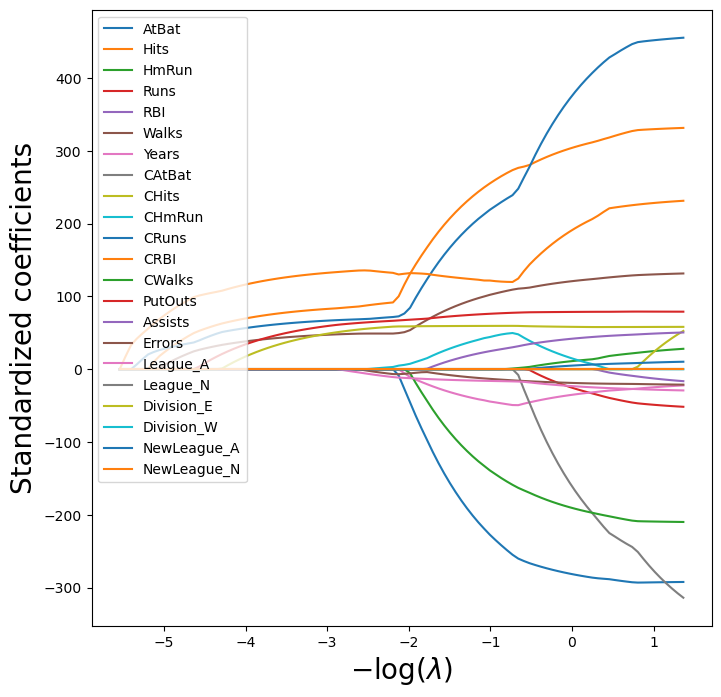

In [53]:
path_fig, ax = subplots(figsize=(8,8))                  # Create a new figure and axes for plotting with a size of 8x8 inches

soln_path.plot(ax=ax, legend=False)                     # Plot the solution path of coefficients against the negative log of alpha values

ax.legend(loc='upper left')                             # Add a legend to the plot, positioned at the upper left of the figure

ax.set_xlabel('$-\log(\lambda)$', fontsize=20)          # Label the x-axis as '-log(lambda)' with a font size of 20

ax.set_ylabel('Standardized coefficients', fontsize=20);# Label the y-axis as 'Standardized coefficients' with a font size of 20

The smallest cross-validated error is lower than the test set MSE of the null model
and of least squares, and very similar to the test MSE of 115526.71 of ridge
regression with $\lambda$ chosen by cross-validation.

In [54]:
np.min(tuned_lasso.mse_path_.mean(1))  # Find and return the minimum mean cross-validated MSE across all alpha values from the Lasso model

114683.64833737363

Let’s again produce a plot of the cross-validation error.

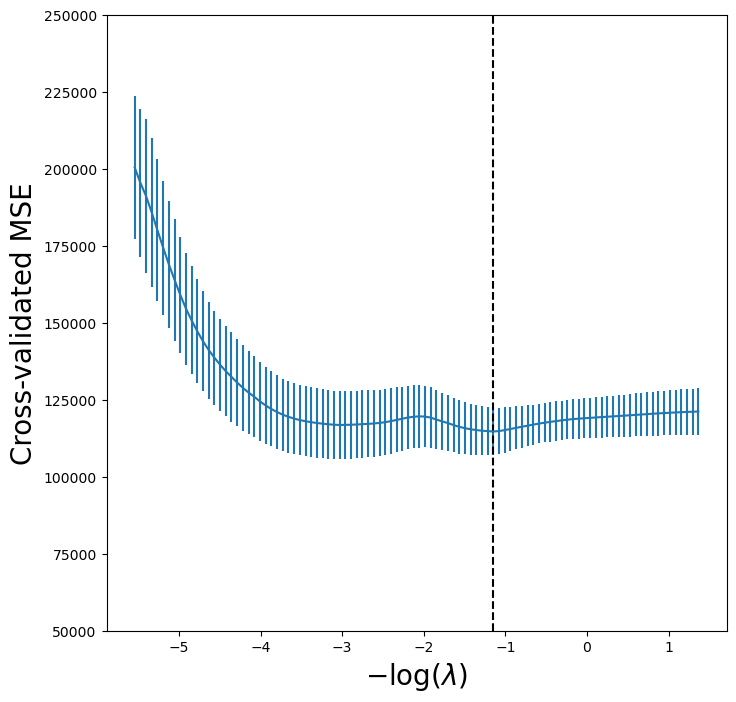

In [55]:
lassoCV_fig, ax = subplots(figsize=(8,8))            # Create a new figure and axes for plotting with a size of 8x8 inches

ax.errorbar(-np.log(tuned_lasso.alphas_),            # Plot the negative log of alpha values on the x-axis
            tuned_lasso.mse_path_.mean(1),           # Plot the mean cross-validated MSE for each alpha on the y-axis
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))  # Add error bars to represent the standard error of the MSE

ax.axvline(-np.log(tuned_lasso.alpha_),              # Draw a vertical line at the optimal alpha value found by LassoCV
           c='k',                                    # Set the color of the line to black
           ls='--')                                  # Use a dashed line style for the vertical line

ax.set_ylim([50000, 250000])                         # Set the limits of the y-axis to range from 50,000 to 250,000

ax.set_xlabel('$-\log(\lambda)$', fontsize=20)       # Label the x-axis as '-log(lambda)' with a font size of 20

ax.set_ylabel('Cross-validated MSE', fontsize=20);   # Label the y-axis as 'Cross-validated MSE' with a font size of 20

However, the lasso has a substantial advantage over ridge regression
in that the resulting coefficient estimates are sparse. Here we see
that 6 of the 19 coefficient estimates are exactly zero. So the lasso
model with $\lambda$ chosen by cross-validation contains only 13
variables.

In [56]:
tuned_lasso.coef_  # Retrieve the coefficients of the model corresponding to the optimal alpha after cross-validation for the Lasso model

array([-2.10048245e+02,  2.43505391e+02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.76824695e+01, -4.15369279e+01, -0.00000000e+00,
        0.00000000e+00,  3.96131741e+01,  2.05763775e+02,  1.24465281e+02,
       -1.26214777e+02,  7.52504772e+01,  2.16261500e+01, -1.20370257e+01,
       -1.56898572e+01,  7.78084821e-15,  5.94797619e+01, -1.74463908e-12,
        0.00000000e+00, -0.00000000e+00])

As in ridge regression, we could evaluate the test error
of cross-validated lasso by first splitting into
test and training sets and internally running
cross-validation on the training set. We leave
this as an exercise.

## PCR and PLS Regression

### Principal Components Regression

Principal components regression (PCR) can be performed using
`PCA()`  from the `sklearn.decomposition`
module. We now apply PCR to the  `Hitters`  data, in order to
predict `Salary`. Again, ensure that the missing values have
been removed from the data.

We use `LinearRegression()`  to fit the regression model
here. Note that it fits an intercept by default, unlike
the `OLS()` function seen earlier.

In [57]:
pca = PCA(n_components=2)              # Initialize PCA to reduce dimensionality to 2 components
linreg = skl.LinearRegression()        # Initialize a Linear Regression model

pipe = Pipeline([('pca', pca),         # Create a pipeline with PCA as the first step
                 ('linreg', linreg)])  # Add Linear Regression as the second step in the pipeline

pipe.fit(X, Y)                         # Fit the pipeline to the feature matrix X and target vector Y

pipe.named_steps['linreg'].coef_       # Retrieve the coefficients of the fitted Linear Regression model

array([0.09845296, 0.47588098])

    The first coefficient `0.09845296` corresponds to the first principal component.
    The second coefficient `0.47588098` corresponds to the second principal component.

When performing PCA, the results vary depending
on whether the data has been *standardized* or not.
As in the earlier examples, this can be accomplished
by including an additional step in the pipeline.

In [58]:
pipe = Pipeline([('scaler', scaler),        # Create a pipeline with a scaler to standardize the features
                 ('pca', pca),              # Add PCA to reduce dimensionality to 2 components
                 ('linreg', linreg)])       # Add Linear Regression as the final step in the pipeline

pipe.fit(X, Y)                              # Fit the pipeline to the feature matrix X and target vector Y

pipe.named_steps['linreg'].coef_            # Retrieve the coefficients of the fitted Linear Regression model

array([105.22444337,  -4.18121859])

The result array([105.22444337, -4.18121859]) represents the coefficients of the Linear Regression model after applying scaling and PCA on the data. 

Coefficients Interpretation:

* The first value 105.22444337 corresponds to the weight (coefficient) of the first principal component from the PCA transformation.
* The second value -4.18121859 corresponds to the weight of the second principal component.

Magnitude and Direction:

* A positive coefficient (105.22444337) suggests that an increase in the first principal component is associated with a significant increase in the predicted value of Y.
* A negative coefficient (-4.18121859) suggests that an increase in the second principal component is associated with a decrease in the predicted value of Y.
* The larger magnitude of 105.22444337 compared to -4.18121859 implies that the first principal component has a much stronger impact on the target variable Y.

We can of course use CV to choose the number of components, by
using `skm.GridSearchCV`, in this
case fixing the parameters to vary the
`n_components`.

In [59]:
param_grid = {'pca__n_components': range(1, 20)}           # Define a parameter grid to test different numbers of principal components (from 1 to 19)

grid = skm.GridSearchCV(pipe,                              # Initialize GridSearchCV with the pipeline (scaler + PCA + linear regression)
                        param_grid,                        # Use the parameter grid to search for the best number of PCA components
                        cv=kfold,                          # Use KFold cross-validation for model evaluation
                        scoring='neg_mean_squared_error')  # Optimize based on negative mean squared error as the scoring metric

grid.fit(X, Y)          # Fit GridSearchCV on the feature matrix X and target vector Y to find the best number of PCA components

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

Let’s plot the results as we have for other methods.

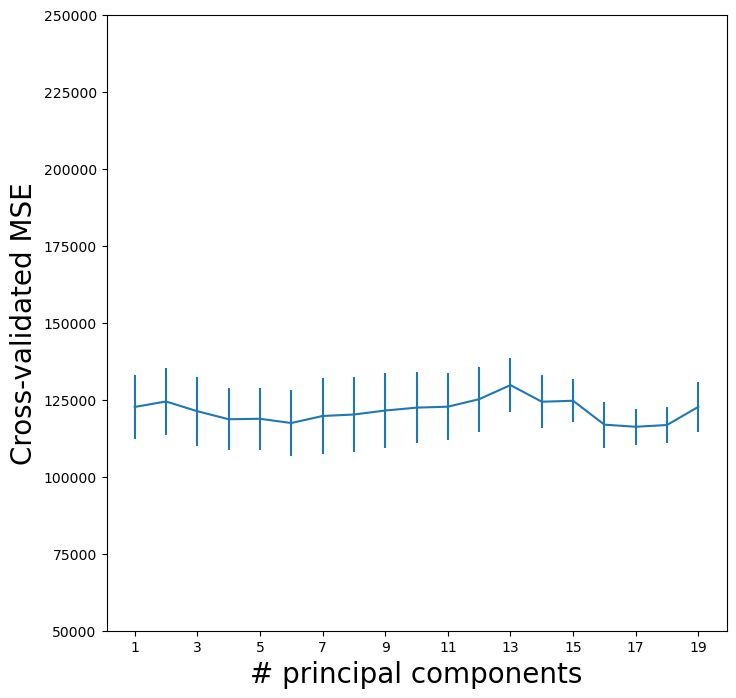

In [60]:
pcr_fig, ax = subplots(figsize=(8,8))          # Create a new figure and axes for plotting with a size of 8x8 inches

n_comp = param_grid['pca__n_components']       # Get the range of principal components tested in the grid search

ax.errorbar(n_comp,                                           # Plot the number of principal components on the x-axis
            -grid.cv_results_['mean_test_score'],             # Plot the negated mean cross-validated MSE on the y-axis
            grid.cv_results_['std_test_score'] / np.sqrt(K))  # Add error bars representing the standard error of the MSE

ax.set_ylabel('Cross-validated MSE', fontsize=20)       # Label the y-axis as 'Cross-validated MSE' with font size 20

ax.set_xlabel('# principal components', fontsize=20)    # Label the x-axis as '# principal components' with font size 20

ax.set_xticks(n_comp[::2])       # Set the x-ticks to every other number of principal components

ax.set_ylim([50000, 250000]);    # Set the y-axis limits to range from 50,000 to 250,000

We see that the smallest cross-validation error occurs when
17
components are used. However, from the plot we also see that the
cross-validation error is roughly the same when only one component is
included in the model. This suggests that a model that uses just a
small number of components might suffice.

The CV score is provided for each possible number of components from
1 to 19 inclusive. The `PCA()` method complains
if we try to fit an intercept only with `n_components=0`
so we also compute the MSE for just the null model with
these splits.

In [61]:
Xn = np.zeros((X.shape[0], 1))            # Create a feature matrix Xn with all zeros, having the same number of rows as X and a single column

cv_null = skm.cross_validate(linreg,      # Perform cross-validation using a linear regression model
                             Xn,          # Use the zero feature matrix Xn as input data
                             Y,           # Use the target vector Y for predictions
                             cv=kfold,    # Use KFold cross-validation strategy for evaluation
                             scoring='neg_mean_squared_error')  # Use negative mean squared error as the scoring metric

-cv_null['test_score'].mean()             # Return the mean of the negated cross-validated test scores to get the actual mean squared error

204121.0143146298

The `explained_variance_ratio_`
attribute of our `PCA` object provides the *percentage of variance explained* in the predictors and in the response using
different numbers of components.

In [62]:
pipe.named_steps['pca'].explained_variance_ratio_  # Retrieve the explained variance ratio of each principal component from the PCA step in the pipeline

array([0.33351942, 0.19832967])

Briefly, we can think of
this as the amount of information about the predictors
that is captured using $M$ principal components. For example, setting
$M=1$ only captures 33.35% of the variance, while $M=2$ captures an additional 19.83%, for a total of 53.18% of the variance.


By  $M=6$ it increases to
88.63%. Beyond this the increments continue to diminish, until we use all $M=p=19$ components, which captures all  100% of the variance.

### Partial Least Squares
Partial least squares (PLS) is implemented in the
`PLSRegression()`  function.

In [63]:
pls = PLSRegression(n_components=2,     # Initialize a Partial Least Squares (PLS) regression model with 2 components
                    scale=True)         # Scale the predictors (X) before fitting the model

pls.fit(X, Y)                           # Fit the PLS regression model on the feature matrix X and target vector Y

PLSRegression()

As was the case in PCR, we will want to
use CV to choose the number of components.

In [64]:
param_grid = {'n_components': range(1, 20)}  # Define a parameter grid to test different numbers of components for PLS (from 1 to 19)

grid = skm.GridSearchCV(pls,                 # Initialize GridSearchCV with the PLS regression model
                        param_grid,          # Use the parameter grid to search for the best number of components
                        cv=kfold,            # Use KFold cross-validation for model evaluation
                        scoring='neg_mean_squared_error')  # Optimize based on negative mean squared error as the scoring metric

grid.fit(X, Y)                               # Fit GridSearchCV on the feature matrix X and target vector Y to find the best number of components

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

As for our other methods, we plot the MSE.

(50000.0, 250000.0)

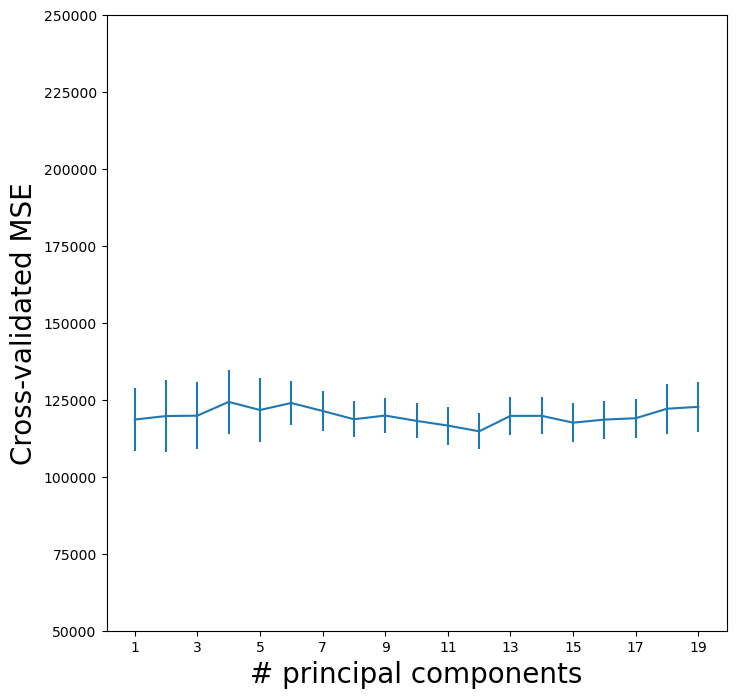

In [65]:
pls_fig, ax = subplots(figsize=(8,8))                     # Create a new figure and axes for plotting with a size of 8x8 inches

n_comp = param_grid['n_components']                       # Get the range of components tested in the grid search

ax.errorbar(n_comp,                                           # Plot the number of components on the x-axis
            -grid.cv_results_['mean_test_score'],             # Plot the negated mean cross-validated MSE on the y-axis
            grid.cv_results_['std_test_score'] / np.sqrt(K))  # Add error bars representing the standard error of the MSE

ax.set_ylabel('Cross-validated MSE', fontsize=20)         # Label the y-axis as 'Cross-validated MSE' with font size 20

ax.set_xlabel('# principal components', fontsize=20)      # Label the x-axis as '# principal components' with font size 20

ax.set_xticks(n_comp[::2])                                # Set the x-ticks to every other number of components

ax.set_ylim([50000, 250000])                              # Set the y-axis limits to range from 50,000 to 250,000

CV error is minimized at 12,
though there is little noticable difference between this point and a much lower number like 2 or 3 components.